In [34]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [23]:
molecule_matrix = pd.read_csv('./Dataset/Molecule_matrix_mold2.csv',dtype={'CID':'str'})

In [24]:
CID = np.array(molecule_matrix['CID'])
label = np.array(molecule_matrix['outcome'])
molecule_matrix_ = np.array(molecule_matrix.iloc[:,1:molecule_matrix.shape[1]-1])

In [25]:
label[label=='active']=1
label[label=='inactive']=0
label = label.astype('int')

In [26]:
print(molecule_matrix_.shape)
print(Counter(label))

(302630, 648)
Counter({0: 301747, 1: 883})


In [39]:
ratio = {0:8000,1:883}
rus = RandomUnderSampler(ratio=ratio, replacement=False, return_indices=True)
x_resample, y_resample, indices = rus.fit_sample(molecule_matrix_,label)

### Random Forest

In [40]:
x_train,x_test,y_train,y_test = train_test_split(x_resample,y_resample,test_size = 0.2)

In [41]:
highest_cross_val_accu = -1
best_t = None
indices = range(x_train.shape[0])
tree = np.arange(10,100,10)
kf = KFold(n_splits=5,shuffle=True,random_state=28584096)

for n_tree in tree:
    accuracies = []
    for train_indices, val_indices in kf.split(indices):
        x_tr = x_train[train_indices]
        y_tr = y_train[train_indices]
        cf = RandomForestClassifier(n_estimators=n_tree)
        cf.fit(x_tr,y_tr)
        pred = cf.predict(x_train[val_indices])
        acc = accuracy_score(y_true=y_train[val_indices],y_pred=pred)
        accuracies.append(acc)
    cross_val_acc = np.mean(accuracies)
    print('N_tree: ', n_tree, 'cross validation accuracy:', cross_val_acc)
    if cross_val_acc > highest_cross_val_accu:
        highest_cross_val_accu = cross_val_acc
        best_t = n_tree
print('Best N_tree: ',best_t, '; cross-validation accuracy: ',highest_cross_val_accu)

N_tree:  10 cross validation accuracy: 0.900648005456
N_tree:  20 cross validation accuracy: 0.905291830103
N_tree:  30 cross validation accuracy: 0.902196606855
N_tree:  40 cross validation accuracy: 0.903463122482
N_tree:  50 cross validation accuracy: 0.905995856803
N_tree:  60 cross validation accuracy: 0.903744812344
N_tree:  70 cross validation accuracy: 0.905151974947
N_tree:  80 cross validation accuracy: 0.904448047224
N_tree:  90 cross validation accuracy: 0.904307796158
Best N_tree:  50 ; cross-validation accuracy:  0.905995856803


In [44]:
rf = RandomForestClassifier(n_estimators=best_t)
rf.fit(x_train,y_train)
pred = rf.predict(x_test)
pred_prob = rf.predict_proba(x_test)
np.mean(pred!=y_test)

0.10129431626336523

In [49]:
fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=pred_prob[:,1])

Text(0.5,1,'ROC curve')

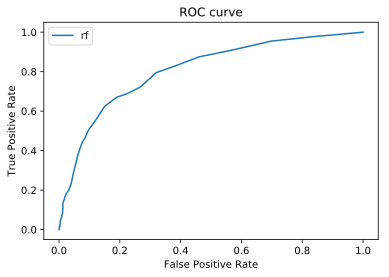

In [50]:
plt.plot(fpr,tpr,label='rf')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC curve')

### XGboost

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_resample,y_resample,test_size = 0.2)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train)

In [8]:
train = xgb.DMatrix(x_train,y_train)
val = xgb.DMatrix(x_val,y_val)
test = xgb.DMatrix(x_test,y_test)

In [9]:
# set the parameters for xgboost
scale = float(np.sum(y_resample==0)/np.sum(y_resample==1))
param = {'gamma':0.8,'max_depth':6,'objective':'binary:logistic','eval_metric':'auc','scale_pos_weight':scale}
num_round = 15
watchlist = [(val,'eval'),(train,'train')]

In [10]:
# train the model
evals_result = dict()
bst = xgb.train(params=param,dtrain=train,num_boost_round=num_round,evals=watchlist,evals_result=evals_result)

[0]	eval-auc:0.699261	train-auc:0.878655
[1]	eval-auc:0.758516	train-auc:0.915085
[2]	eval-auc:0.759987	train-auc:0.933848
[3]	eval-auc:0.764616	train-auc:0.953007
[4]	eval-auc:0.770372	train-auc:0.962116
[5]	eval-auc:0.776451	train-auc:0.970219
[6]	eval-auc:0.775185	train-auc:0.975239
[7]	eval-auc:0.772189	train-auc:0.982113
[8]	eval-auc:0.776605	train-auc:0.983543
[9]	eval-auc:0.781528	train-auc:0.98564
[10]	eval-auc:0.776639	train-auc:0.989985
[11]	eval-auc:0.778432	train-auc:0.992421
[12]	eval-auc:0.776556	train-auc:0.993819
[13]	eval-auc:0.779066	train-auc:0.994666
[14]	eval-auc:0.780584	train-auc:0.996265
[15]	eval-auc:0.780961	train-auc:0.996781
[16]	eval-auc:0.781178	train-auc:0.998118
[17]	eval-auc:0.781308	train-auc:0.998606
[18]	eval-auc:0.78463	train-auc:0.998829
[19]	eval-auc:0.784616	train-auc:0.999158
[20]	eval-auc:0.78668	train-auc:0.999346
[21]	eval-auc:0.78977	train-auc:0.99942
[22]	eval-auc:0.789937	train-auc:0.999588
[23]	eval-auc:0.790654	train-auc:0.999735
[24]	ev

In [11]:
train_auc = evals_result['train']['auc']
eval_auc = evals_result['eval']['auc']

Text(0,0.5,'Area Under ROC curve')

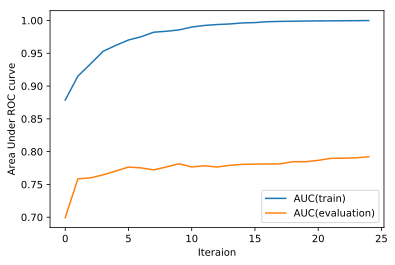

In [12]:
plt.plot(train_auc,label='AUC(train)')
plt.plot(eval_auc,label='AUC(evaluation)')
plt.legend()
plt.xlabel('Iteraion')
plt.ylabel('Area Under ROC curve')

In [13]:
# set the cut-off threshold to 0.4 
pred = bst.predict(test)
y_preds = [1 if p>0.4 else 0 for p in pred]

In [14]:
# metric measurement: 1). Accuracy 
label =  test.get_label()
print('Accuracy:', 1- np.mean(y_preds != label))

Accuracy: 0.85368598762


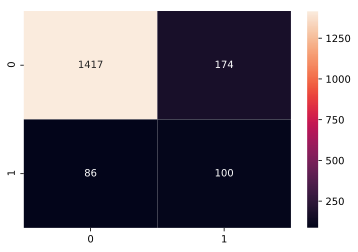

In [15]:
# 2). confustion matrix
cm = confusion_matrix(y_pred=y_preds,y_true=label)
sns.heatmap(cm,annot=True,fmt='d')

In [16]:
# 3). True positive rate and False negative rate
tn,fp,fn,tp = confusion_matrix(y_pred=y_preds,y_true=label).ravel()
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
print('True positive rate:', tpr)
print('False negative rate:', fnr)

True positive rate: 0.537634408602
False negative rate: 0.462365591398


In [19]:
# 4). auc
print('AUC:', roc_auc_score(y_true=label,y_score=pred))

AUC: 0.816822448855


In [20]:
# 5). ROC curve
fpr,tpr,thresholds = roc_curve(y_true=label,y_score=pred)

Text(0.5,1,'ROC curve')

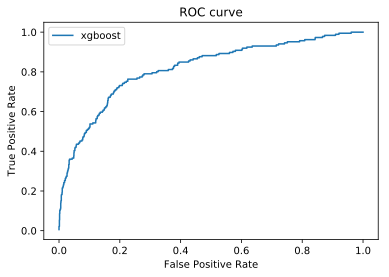

In [21]:
plt.plot(fpr,tpr,label='xgboost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC curve')